In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from matplotlib import patches
from PIL import Image
from skimage import color, measure, data, feature
from skimage.filters import threshold_otsu
from skimage.feature import Cascade
from skimage.transform import resize, rescale
import glob, sys
import io
from pdf2image import convert_from_path
from pdf2image.exceptions import (
    PDFInfoNotInstalledError,
    PDFPageCountError,
    PDFSyntaxError
)
from PyPDF2 import PdfReader
import cv2
import scipy
import os

# Multipass

In [402]:
def pdf_collector():
    os.getcwd()
    file = glob.glob("*.pdf")
    file.sort(key=os.path.getmtime)
    pdf_files = list(file)
    return pdf_files

# Pdf to png

In [95]:
def pdf_to_png(pdf_path):
  #poppler_path = "/home/bmt22/poppler-0.68.0/bin"
  images = convert_from_path(pdf_path=pdf_path)
  for count, img in enumerate(images):
    img_name = f"page_{count}.png"  
    img.save(img_name, "PNG")
  return images

# Face detection

In [91]:
def init_face_detector():
    # Load the trained file from the module root.
    trained_file = data.lbp_frontal_face_cascade_filename()

    # Initialize the detector cascade.
    detector = Cascade(trained_file)
    return detector

In [412]:
def face_detector(images, detector):
    for i in range(len(images)):
        #image = Image.open(i)
        npim = np.array(images[i], dtype='uint8' )
        detected = detector.detect_multi_scale(img=npim, scale_factor=1.2, step_ratio=1, min_size=(1000, 800), max_size=(2000, 1500))
        if len(detected) != 0:
            break
    return npim, images[i] #, images[i+1]

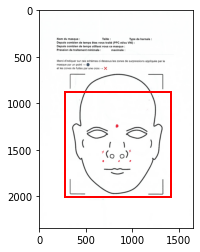

In [288]:
plt.imshow(npim)
img_desc = plt.gca()
plt.set_cmap('gray')

for patch in detected:

    img_desc.add_patch(
        patches.Rectangle(
            (patch['c'], patch['r']),
            patch['width'],
            patch['height'],
            fill=False,
            color='r',
            linewidth=2
        )
    )

plt.show()

# Bordure detection

In [120]:
def bordure_detection(face):
  # Read image
  #face = cv2.imread(path)
  
  # Convert image to grayscale
  gray = cv2.cvtColor(face,cv2.COLOR_BGR2GRAY)
  
  # Use canny edge detection
  edges = cv2.Canny(gray,50,150,apertureSize=3)
  
  # Apply HoughLinesP method to
  # to directly obtain line end points
  #lines_list = list()
  lines = cv2.HoughLinesP(
              edges, # Input edge image
              1, # Distance resolution in pixels
              np.pi/180, # Angle resolution in radians
              threshold=100, # Min number of votes for valid line
              minLineLength=130, # Min allowed length of line
              maxLineGap=10 # Max allowed gap between line for joining them
              )
  X, Y = list(), list()
  # Iterate over points
  for points in lines:
      # Extracted points nested in the list
      x1,y1,x2,y2=points[0]
      # Draw the lines joing the points
      # On the original image
      if x1 == x2 :
        # Maintain a simples lookup list for points
        cv2.line(face,(x1,y1),(x2,y2),(0,255,0),2)
        X.append(x1); X.append(x2)
        Y.append(y1); Y.append(y2)
  # Save the result image
  #cv2.imwrite('detectedLines.png',face)
  return X, Y

In [138]:
def im_croping(X, Y, img):
    left = np.min(X)
    top = np.min(Y)
    right = np.max(X)
    bottom = np.max(Y)
    #height = np.shape(etalon)[0]
    #width = np.shape(etalon)[1]
    delta = 30

    img_res = img.crop((left - delta, top - delta, right + delta, bottom + delta)) 
    #final_res = np.array(img_res, dtype='uint8' )
    #final_res = resize(final_res, (height, width), anti_aliasing=True)
    return img_res

# Annotation detection and storage

In [427]:
def find_contours(im_with_face):
    # Convert from RGB-VGA to RGB format
    im_test_rgb = im_with_face.convert('RGB')

    # Convert into grayscale image
    im_test_gray = color.rgb2gray(im_test_rgb)

    # Use threshold otsu to be able to find contours
    thresh = threshold_otsu(im_test_gray)
    im_thresh = im_test_gray > thresh
    contours = measure.find_contours(im_thresh, 0.8)
    fig, ax = plt.subplots()
    ax.imshow(im_thresh, cmap=plt.cm.gray)
    for contour in contours:
        #if contour.shape < (130, 2) and contour.shape > (15, 2):
        plt.plot(contour[:,1], contour[:,0], linewidth=1)
    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    return contours, im_thresh

In [423]:
def calibration():
    path = '/home/bmt22/Face report/Reference/Reference.PNG' 
    sample = Image.open(path)
    np_sample = np.array(sample)
    X_cal, Y_cal = bordure_detection(np_sample)
    img_res = im_croping(X_cal, Y_cal, sample)
    contours_cal, im_thresh = find_contours(img_res)
    return contours_cal, im_thresh

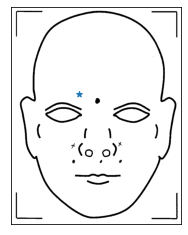

In [384]:
fig, ax = plt.subplots()
ax.imshow(im_thresh, cmap=plt.cm.gray)
plt.scatter(im_thresh.shape[1]*2/5, im_thresh.shape[0]*2/5, marker='*')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

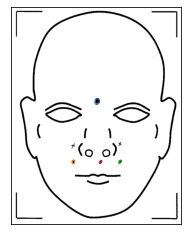

In [337]:
fig, ax = plt.subplots()
ax.imshow(im_thresh, cmap=plt.cm.gray)
for contour in contours_storage:
    #if contour.shape < (130, 2) and contour.shape > (15, 2):
    plt.plot(contour[:,1], contour[:,0], linewidth=1)
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [390]:
def store_contours(contours_storage):
    for contour in contours:
        if contour.shape < (130, 2):
            col_center = np.mean(contour[:, 1])
            row_center = np.mean(contour[:, 0])
            if row_center > im_thresh.shape[1] * 2/5:
                contours_storage.append(contour)
            elif col_center < im_thresh.shape[0] * 3/5 and col_center > im_thresh.shape[0] * 2/5:
                contours_storage.append(contour)
    return contours_storage

# Main

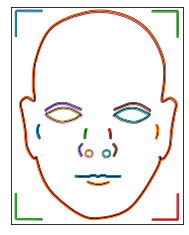

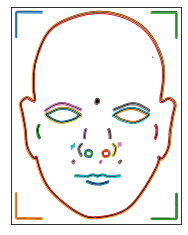

AttributeError: 'list' object has no attribute 'shape'

In [438]:
init=0
contours_storage, contours = list(), list()
pdf_files = pdf_collector()
images = pdf_to_png(pdf_files[1])
if init == 0:
    detector = init_face_detector()
    init += 1
np_im_with_face, im_with_face = face_detector(images, detector)
X, Y = bordure_detection(np_im_with_face)
img_res = im_croping(X, Y, im_with_face)
contours_cal, im_thresh = calibration()
contours = find_contours(img_res)
contours_storage = store_contours(contours_storage)

In [440]:
#for contour in contours:
#    print(contour.shape)
len(contours[0][0])

669

### To do
-   Organiser le répertoire
-   Build project
-   Mettre images dans un tmp
-   Supprimer images après usage
-   Pourquoi contours est devenu une liste de contours ??
-   Voir si utiliser var ou std pour identifier croix / rond
-   Flask pour serveur: associe un url à une fonction pour partage pdf de portrait